In [1]:
from os import path

import sys
sys.path.append(path.join("..", "notebooks"))
sys.path.append(path.join("..", "notebooks", "utils.py"))
import utils

from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import anndata
import scanpy as sc

In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "macosko_2015.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 44808 × 23743 
    obs: 'batch_id', 'cluster_id', 'labels'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.08
Chosen offset: 0.19
Chosen offset: 0.71


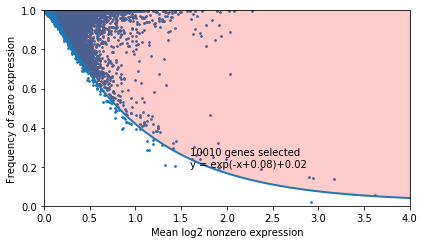

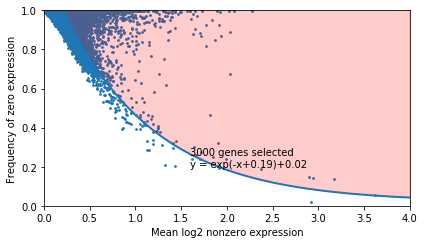

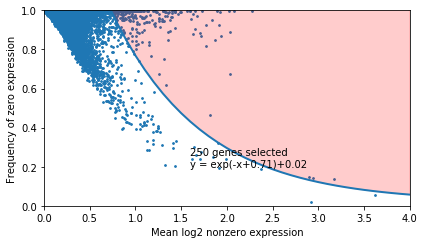

In [4]:
gene_mask_10000 = utils.select_genes(adata.X, n=10000, threshold=0)
gene_mask_3000 = utils.select_genes(adata.X, n=3000, threshold=0)
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)

In [5]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [6]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [7]:
adata_250 = adata_norm[:, gene_mask_250].copy()
adata_3000 = adata_norm[:, gene_mask_3000].copy()
adata_10000 = adata_norm[:, gene_mask_10000].copy()

In [8]:
%%time
for adata_ in [adata_250, adata_3000, adata_10000]:
    print("Computing PCA for %d genes" % adata_.shape[1])
    U, S, V = np.linalg.svd(adata_.X, full_matrices=False)
    U[:, np.sum(V, axis=1) < 0] *= -1
    adata_.obsm["pca"] = np.dot(U, np.diag(S))
    adata_.obsm["pca"] = adata_.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

Computing PCA for 250 genes
Computing PCA for 3000 genes
Computing PCA for 10010 genes
CPU times: user 1h 17min 44s, sys: 2min 57s, total: 1h 20min 42s
Wall time: 2min 43s
Compiler : 146 ms


## Run t-SNE

In [9]:
%%time
for adata_ in [adata_250, adata_3000, adata_10000]:
    print("Computing t-SNE for %d genes" % adata_.shape[1])
    affinities = affinity.Multiscale(
        adata_.obsm["pca"],
        perplexities=[50, 500],
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    init = initialization.pca(adata_.obsm["pca"], random_state=42)
    embedding = TSNEEmbedding(
        init,
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
    )
    embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
    embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)
    
    adata_.obsm["tsne"] = embedding

Computing t-SNE for 250 genes
Computing t-SNE for 3000 genes
Computing t-SNE for 10010 genes
CPU times: user 7h 56min 59s, sys: 1min 13s, total: 7h 58min 12s
Wall time: 23min


In [10]:
adata_250.write_h5ad("macosko_embedding_tsne_250_genes.h5ad")
adata_3000.write_h5ad("macosko_embedding_tsne_3000_genes.h5ad")
adata_10000.write_h5ad("macosko_embedding_tsne_10000_genes.h5ad")

In [11]:
adata_250 = anndata.read_h5ad("macosko_embedding_tsne_250_genes.h5ad")
adata_3000 = anndata.read_h5ad("macosko_embedding_tsne_3000_genes.h5ad")
adata_10000 = anndata.read_h5ad("macosko_embedding_tsne_10000_genes.h5ad")

In [42]:
colors = utils.MACOSKO_COLORS

In [13]:
legend_kwargs = dict(loc="center", bbox_to_anchor=(0.5, -0.05), ncol=len(np.unique(adata.obs["labels"])))

Text(0, 1.02, 'c')

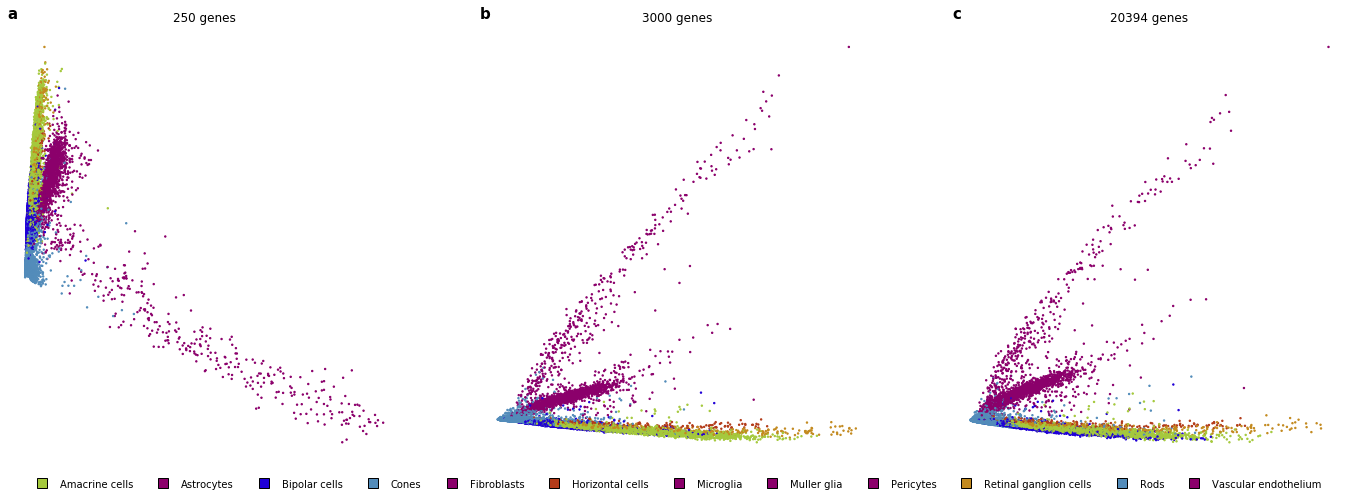

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["pca"], adata.obs["labels"],  s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(adata_10000.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

Text(0, 1.02, 'c')

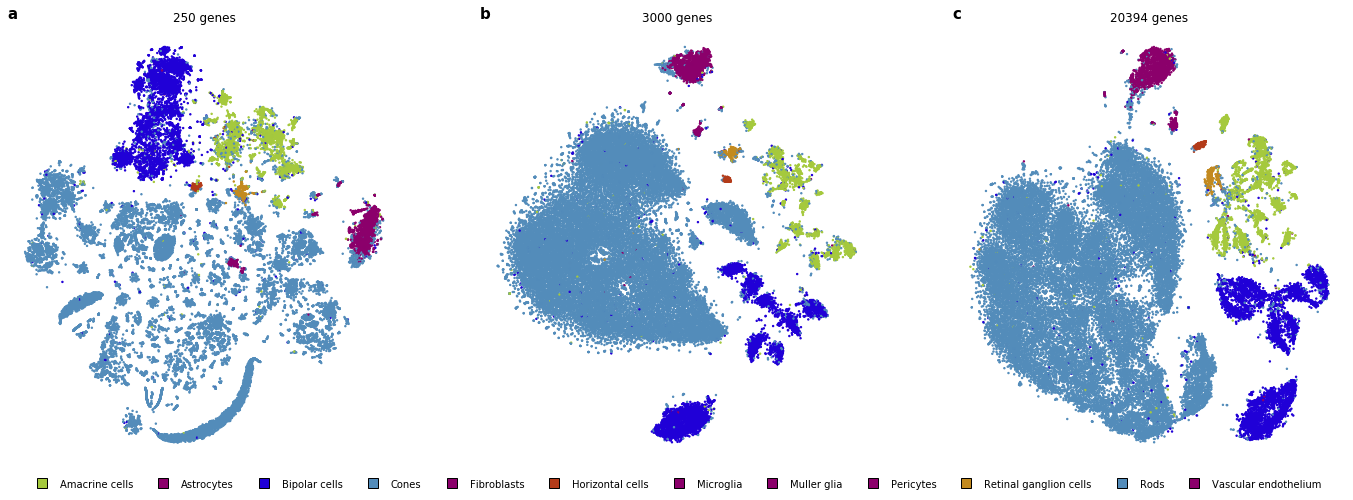

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["tsne"],  adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
           legend_kwargs=legend_kwargs)
utils.plot(adata_10000.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

## Transform

In [16]:
new = anndata.read_h5ad(path.join("..", "data", "shekhar_2016.h5ad"))

In [17]:
new.obs["labels"].value_counts()

Bipolar cells     23494
Muller glia        2945
Amacrine cells      252
Rods                 91
Cones                48
Name: labels, dtype: int64

In [18]:
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
cell_mask.sum()

26830

In [19]:
new = new[cell_mask].copy()

In [20]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['KITL', 'TMTC3', 'CEP290', '4930430F08RIK', '1700017N19RIK', 'MGAT4C',
       'RASSF9', 'LRRIQ1', 'ADGB', 'SLC6A15',
       ...
       'GM9047', 'DOXL2', 'FABP1', 'GM16336', '1700018B08RIK', 'GM23986',
       'TREH', 'BC050972', 'GM23791', 'VSIG1'],
      dtype='object', name='index', length=20512)

In [21]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [22]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 0.71
Chosen offset: 0.36
Chosen offset: 0.14


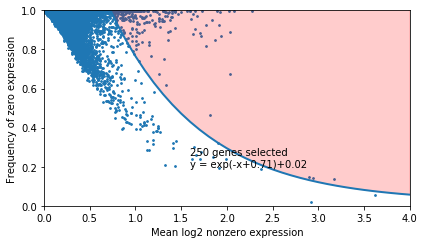

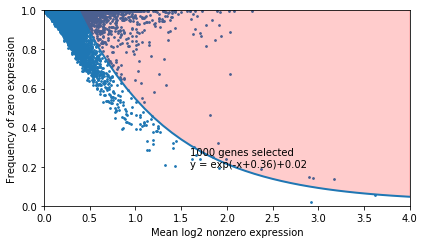

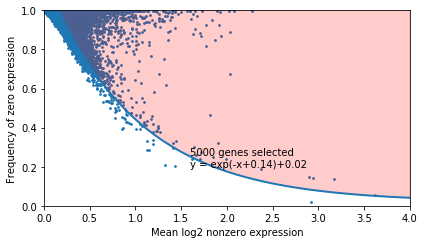

In [23]:
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)
gene_mask_1000 = utils.select_genes(adata.X, n=1000, threshold=0)
gene_mask_5000 = utils.select_genes(adata.X, n=5000, threshold=0)

In [24]:
adata_250 = adata[:, gene_mask_250].copy()
adata_1000 = adata[:, gene_mask_1000].copy()
adata_5000 = adata[:, gene_mask_5000].copy()

new_250 = new[:, gene_mask_250].copy()
new_1000 = new[:, gene_mask_1000].copy()
new_5000 = new[:, gene_mask_5000].copy()

In [35]:
%%time
affinity_obs = {}
for adata_, new_ in [(adata_250, new_250), (adata_1000, new_1000), (adata_5000, new_5000)]:
    print("Running transform for %d genes" % adata_.shape[1])
    affinities = affinity.PerplexityBasedNN(
        adata_.X.toarray() if sp.issparse(adata_.X) else adata_.X,
        perplexity=30,
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    affinity_obs[adata_.shape[1]] = affinities
    embedding = TSNEEmbedding(
        adata_3000.obsm["tsne"],
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
        callbacks=[ErrorLogger()],
    )
    new_embedding = embedding.prepare_partial(new_.X.toarray(), k=10)
    new_.obsm["tsne_init"] = new_embedding.copy()
    
    new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, inplace=True)
    new_.obsm["tsne"] = new_embedding

Running transform for 250 genes
Iteration   50, KL divergence  380619.8075, 50 iterations in 2.8220 sec
Iteration  100, KL divergence  380582.7272, 50 iterations in 3.1214 sec
Iteration  150, KL divergence  380556.5190, 50 iterations in 3.1950 sec
Iteration  200, KL divergence  380524.1068, 50 iterations in 2.7869 sec
Iteration  250, KL divergence  380495.1670, 50 iterations in 2.5750 sec
Running transform for 1000 genes
Iteration   50, KL divergence  371470.8855, 50 iterations in 2.6413 sec
Iteration  100, KL divergence  371408.6026, 50 iterations in 2.8486 sec
Iteration  150, KL divergence  371401.1403, 50 iterations in 2.8607 sec
Iteration  200, KL divergence  371396.9660, 50 iterations in 3.2729 sec
Iteration  250, KL divergence  371401.3873, 50 iterations in 3.6230 sec
Running transform for 5000 genes
Iteration   50, KL divergence  388666.9028, 50 iterations in 2.5679 sec
Iteration  100, KL divergence  388516.0807, 50 iterations in 2.5093 sec
Iteration  150, KL divergence  388457.

In [36]:
new_250.write_h5ad("macosko_transform_tsne_250_genes.h5ad")
new_1000.write_h5ad("macosko_transform_tsne_1000_genes.h5ad")
new_5000.write_h5ad("macosko_transform_tsne_5000_genes.h5ad")

In [37]:
new_250 = anndata.read_h5ad("macosko_transform_tsne_250_genes.h5ad")
new_1000 = anndata.read_h5ad("macosko_transform_tsne_1000_genes.h5ad")
new_5000 = anndata.read_h5ad("macosko_transform_tsne_5000_genes.h5ad")

In [38]:
new_5000.shape

(26830, 5000)

Text(0, 1.02, 'c')

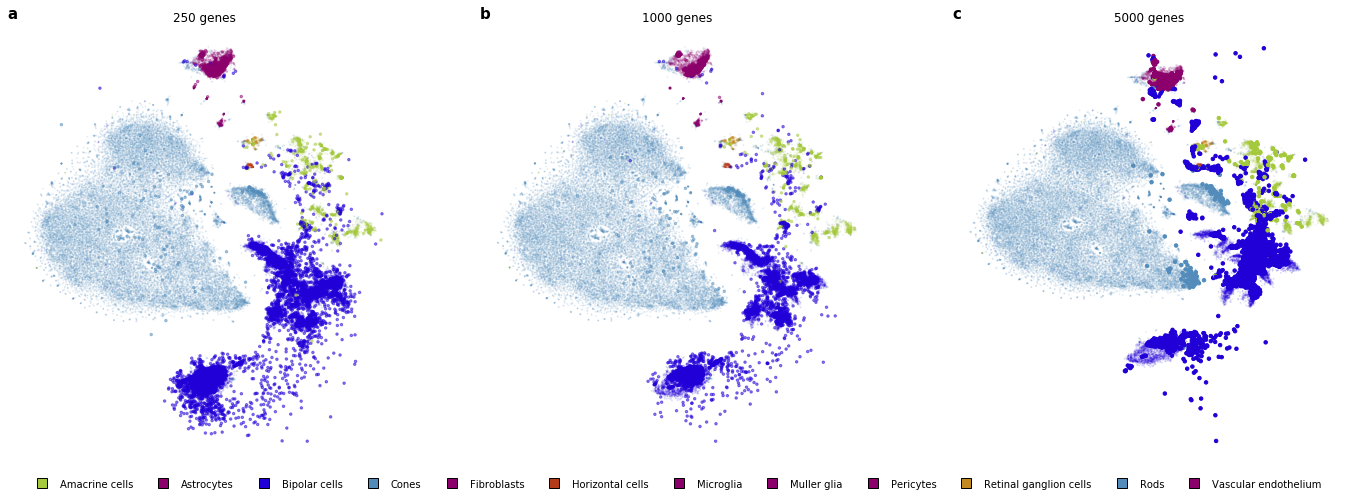

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[0], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[0], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=True, ax=ax[1], alpha=0.1, title="1000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[1], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[2], alpha=0.1, title="5000 genes", label_order=list(colors.keys()))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[2], alpha=1, label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

Text(0, 1.02, 'd')

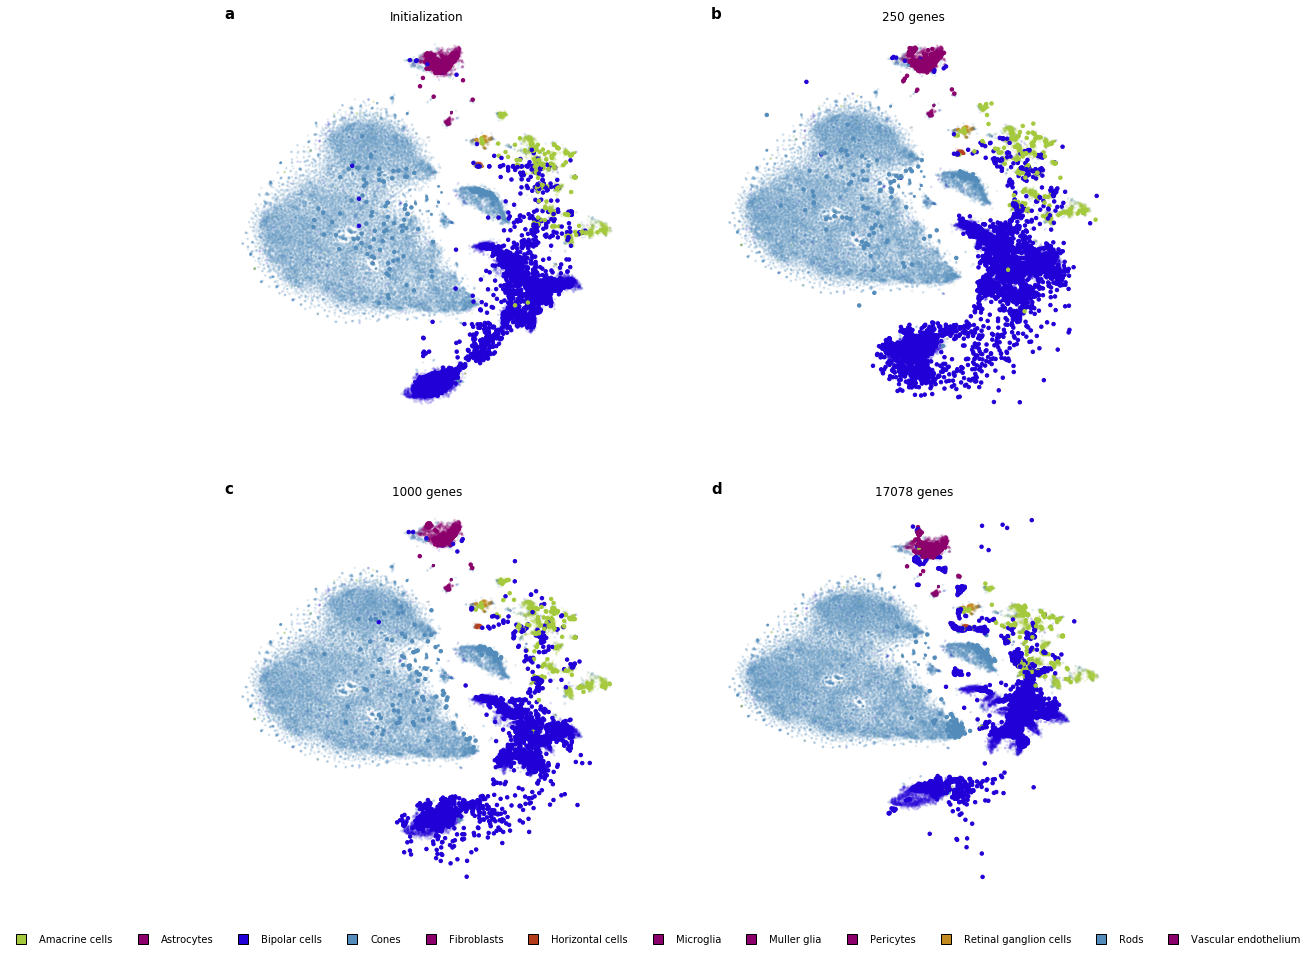

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

fig.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")